In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-SXM2-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 1   # Mini-batch size
num_epochs = 40
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
%matplotlib inline

dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


## 데이터 전처리 함수 정의 (Dataset)

In [5]:
with open("sdf.pickle","rb") as sdf:
    sorted_df = pickle.load(sdf)
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [6]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train_all.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2
#https://gist.github.com/ernestum/601cdf56d2b424757de5 elastic transform
train_transform = A.Compose([ToTensorV2()])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)


loading annotations into memory...
Done (t=5.03s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [7]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [8]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 2}, {'Styrofoam', 7}, {8, 'Plastic bag'}]


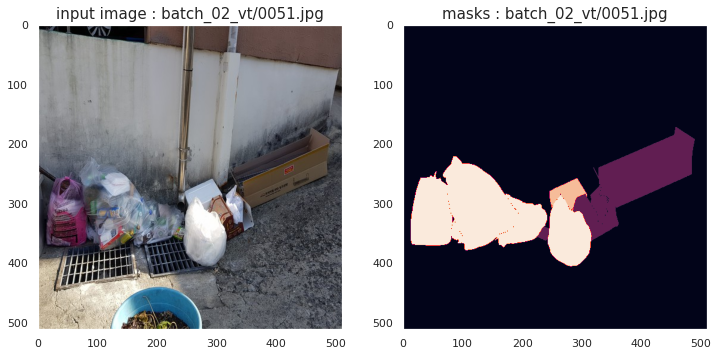

In [9]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [10]:
classdict = {
    3: [], # 3: 'Paper pack'
    4: [], # 4: 'Metal'
    5: [], # 5: 'Glass'
    9: [], # 9: 'Battery'
    10: [], # 10: 'Clothing'
}

tfms_to_small = A.Compose([
    A.Resize(256, 256),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.RandomRotate90(p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=0.5),
    A.Resize(512, 512)
])
tfms_to_big = A.Compose([
    A.CropNonEmptyMaskIfExists(256, 256, ignore_values=[0]),
    A.RandomRotate90(p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.Resize(512, 512)
])
tfms = A.Compose([
    A.RandomRotate90(p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=0.5),
    A.Resize(512, 512)
])

import copy
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]

    mask = masks[0].numpy().astype(np.uint8)
    img = imgs[0].permute([1, 2, 0]).numpy()
    
    mask[mask == 1] = 0
    mask[mask == 2] = 0
    mask[mask == 6] = 0
    mask[mask == 7] = 0
    mask[mask == 8] = 0
    class_type = np.unique(mask)
    if len(class_type) == 1:
        continue    
        
    mask3d = np.dstack([mask]*3)
    res = np.where(mask3d, 0, img)
    res1 = cv2.bitwise_and(img, img, mask=mask)
    for j in class_type:
        if j == 0:
            continue
            
        temp_mask = copy.deepcopy(mask)
        temp_mask[temp_mask != j] = 0    
        if (np.sum(temp_mask != 0)) < 400:
            continue
        temp = copy.deepcopy(res1)
        temp = cv2.bitwise_and(temp, temp, mask=temp_mask)  
        if np.sum(temp != 0) > 20000:
            transformed = tfms_to_small(image=temp, mask=temp_mask)
            mask = transformed['mask']
            temp = transformed['image']
            
        elif np.sum(temp != 0) < 5000:
            transformed = tfms_to_big(image=temp, mask=temp_mask)
            mask = transformed['mask']
            temp = transformed['image']     
            
        else:
            transformed = tfms(image=temp, mask=temp_mask)
            mask = transformed['mask']
            temp = transformed['image']
#        fig, axes = plt.subplots(1, 2)
#        axes[0].imshow(res)
#        axes[1].imshow(temp)
        if np.sum(temp != 0) >= 400: 
            classdict[j].append(temp)

# save data
import pickle
with open('classdict.pickle','wb') as fw:
    pickle.dump(classdict, fw)

In [11]:
imgs, masks, image_infos = next(iter(train_loader))

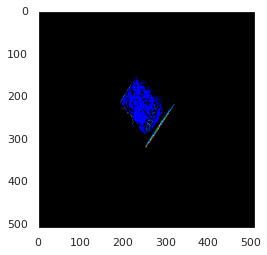

In [38]:
plt.imshow(classdict[3][3]*255)

In [ ]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print(f'Start training..')
    n_class = 11
    best_loss = 9999999
    best_miou = 0
    for epoch in range(num_epochs):
        model.train()

        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       
            masks = torch.stack(masks).long() 
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # device 할당
            model = model.to(device)
            
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], \
                        Loss: {round(loss.item(),4)}, mIoU: {round(mIoU,4)}')
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, mious = validation(epoch + 1, model, val_loader, criterion, device)
            if mious > best_miou:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                best_miou = mious
                save_model(model, saved_dir)
'''
            if avrg_loss < best_loss:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                best_loss = avrg_loss
                save_model(model, saved_dir)
'''

In [ ]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       
            masks = torch.stack(masks).long()  

            images, masks = images.to(device), masks.to(device)            
            
            # device 할당
            model = model.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]
        
        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch}  Average Loss: {round(avrg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                mIoU: {round(mIoU, 4)}')
        print(f'IoU by class : {IoU_by_class}')
        
    return avrg_loss, round(mIoU, 4)